## Intro

Over the past few years online conversations over social media, communities have become very influential and is turning out to be negative. People have different opinions and they sometimes tend to express it as an insult/threat. Due to this reason several platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google, builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations. Previously when the models were build to recognize toxicity in the comments they found that the models incorrectly learned to associate the names of frequently attacked identities with toxicity. Models predicted the comments which includes the mention of such identities(gay, homosexual, asian, black, white, etc) as toxic even though they are not. This happens because these identities are referred in offensive ways. Hence Conversation AI team held a challenge on Kaggle named Jigsaw Unintended Bias in Toxicity Classification.

## Problem Statement

In this project we will build a model that detects the toxic comments, keeping in mind the unintended identity bias. We will also analyze and extract the topics that receive the toxic response on internet.

This will assist online communities to remove such toxic comments and help online discussion become more productive in future.

**This notebook contains the data cleaning and visual exploratory section.**

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
import string

import nltk
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.utils import lemmatize

import spacy

from google.colab import drive

In [ ]:
#Downloading stopwords from nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Train Data

### Import Data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Capstone/Data/

/content/drive/My Drive/Capstone/Data


In [ ]:
train = pd.read_csv("train.csv")

In [ ]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
train.shape

(1804874, 45)

In [ ]:
train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

### About The Data

- The text of individual comment is provided in comment_text and 
each of these comments have a toxicity label in target column.

- The data also have additional toxicity subgroups like **severe_toxicity**, **obscene**, **identity_attack**, **insult** and **threat** for analysis.

- The comments have also been labelled with the identity attribute that has been mentioned in the comment.

- Additionally data also contains some metadeta columns like **publication_id**, **parent_id**, **rating**, **funny**, **likes**, **identity_annotator_count**, **toxicity_annotator_count**, etc. We will remove these meta data columns while cleaning.

### Clean Data

#### Removing Columns 

For classifying the toxic comments we would mainly need the comment text and the target variable. As mentioned above we will not utilize the metadata columns mentioned, hence we will remove them.  <br>
- created_date                                 
- publication_id                               
- parent_id                              
- article_id                                   
- rating                                       
- funny                                        
- wow                                          
- sad                                          
- likes                                        
- disagree                                     
- sexual_explicit                              
- identity_annotator_count                     
- toxicity_annotator_count 

However, we will keep the identity columns for analysis.



In [ ]:
train.drop(columns = ['created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
                    'sad', 'likes', 'disagree', 'sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count'],
           inplace = True)

#### Check Null Values

In [ ]:
train.isnull().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1399744
atheist                                1399744
bisexual                               1399744
black                                  1399744
buddhist                               1399744
christian                              1399744
female                                 1399744
heterosexual                           1399744
hindu                                  1399744
homosexual_gay_or_lesbian              1399744
intellectual_or_learning_disability    1399744
jewish                                 1399744
latino                                 1399744
male         

There are 1399744 null values for columns like identity attribute columns.

I believe the null values persist when the comment does not contain any mention of that identity. Let us confirm this by checking few records.

In [ ]:
train[train['asian'].isnull()][['target', 
                                'comment_text',
                                'severe_toxicity', 
                                'obscene', 
                                'identity_attack', 
                                'insult', 
                                'threat', 
                                'asian']].head(3)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian
0,0.0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.0,0.0,0.0,0.0,0.0,NaN


In [ ]:
train[train['atheist'].isnull()][['target', 
                                'comment_text',
                                'severe_toxicity', 
                                'obscene', 
                                'identity_attack', 
                                'insult', 
                                'threat', 
                                'atheist']].head(3)

,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,atheist
0,0.0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.0,0.0,0.0,0.0,0.0,NaN


Above records confirm that the null values are for identities when they are not mentioned in the comment. Hence we will replace these null values by 0.

In [ ]:
train.fillna(0, inplace = True)

In [ ]:
# Confirm the null values are replaced by 0 

train.isnull().sum()

id                                     0
target                                 0
comment_text                           0
severe_toxicity                        0
obscene                                0
identity_attack                        0
insult                                 0
threat                                 0
asian                                  0
atheist                                0
bisexual                               0
black                                  0
buddhist                               0
christian                              0
female                                 0
heterosexual                           0
hindu                                  0
homosexual_gay_or_lesbian              0
intellectual_or_learning_disability    0
jewish                                 0
latino                                 0
male                                   0
muslim                                 0
other_disability                       0
other_gender    

#### Check Datatypes

In [ ]:
train.dtypes

id                                       int64
target                                 float64
comment_text                            object
severe_toxicity                        float64
obscene                                float64
identity_attack                        float64
insult                                 float64
threat                                 float64
asian                                  float64
atheist                                float64
bisexual                               float64
black                                  float64
buddhist                               float64
christian                              float64
female                                 float64
heterosexual                           float64
hindu                                  float64
homosexual_gay_or_lesbian              float64
intellectual_or_learning_disability    float64
jewish                                 float64
latino                                 float64
male         

All the columns seems to represent correct datatypes. We mainly are concerned with the comment text and target which is object and float respectively. Hence we do not need to make any changes for datatypes.

#### Remove Duplicates If Any

There is a possibility that multiple same comments are available in the dataset. We will drop these duplicated records.

In [ ]:
train.drop_duplicates(subset=['comment_text'], keep='first', inplace = True)

In [ ]:
train.shape

(1780823, 32)

The number of rows dropped from 1804874 to 1780823. There were 24,051 duplicate rows that were deleted.

#### Preprocess

The comments needs to be cleaned and lemmatized for classification. The following steps has been performed while processing the text :
- Removing punctuations, numbers and special characters
- Convert text to lower case
- Tokenize
- Remove stopwords
- Lemmatize



In [ ]:
# Checking data
train[['comment_text']].head()

,comment_text
0,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"
1,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"
2,This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3,Is this something I'll be able to install on my site? When will you be releasing it?
4,haha you guys are a bunch of losers.


In addition to the english stopwords declared in nltk, we will add some general toxic classification stopwords.

In [ ]:
# Declaring stopwords

nltk_stopwords = set(stopwords.words('english'))
all_stopwords = nltk_stopwords.union({'toxic', 'toxicity', 'severe toxic', 'obscene', 'threat', 'insult', 'identity attack', 'identity', 'attack', 'https', 'http', 'www'})

In [ ]:
def text_preprocess(comments, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

  cleaned_comments = []
  lemmatized_comments = []

  for text in comments:
   
    # Converts to lower case, removes special characters, numbers and punctuations
    tokens = simple_preprocess(text, deacc=True)

    # Save the tokens in a list for classification
    cleaned_comments.append(" ".join(tokens))
        
    # Declaring stemmer for lemmatization 
    lemmatizer = PorterStemmer()

    # Converting document to nlp using spacy
    doc = nlp(" ".join(tokens))

    # Remove stopwords, pronunciations and lemmatize text
    lemmatized_comments.append(' '.join([lemmatizer.stem(token.text) if token.text not in all_stopwords and token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))

  return (cleaned_comments, lemmatized_comments)

The above text_preprocess method will return 2 lists: 
- tokenized_comments : Will be used for Bert classification. As we do not need to remove the pronunciations and stopwords for bert model, we will only remove special characters, numbers and convert to lower case.
- lemmatized_comments : Will be used for other baseline models for classification. As models like LogisticRegression, Random Forest, etc need the lemmatized version of text.

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

cleaned, lemmatized = text_preprocess(train['comment_text'])

In [ ]:
cleaned_comments[:5]

['this is so cool it like would you want your mother to read this really great idea well done',
 'thank you this would make my life lot less anxiety inducing keep it up and don let anyone get in your way',
 'this is such an urgent design problem kudos to you for taking it on very impressive',
 'is this something ll be able to install on my site when will you be releasing it',
 'haha you guys are bunch of losers']

In [ ]:
lemmatized_comments[:5]

['cool like would want mother read realli great idea well done',
 'thank would make life lot less anxieti induc keep let anyon get way',
 'urgent design problem kudo take impress',
 'someth abl instal site releas',
 'haha guy bunch loser']

In [ ]:
train['comment_cleaned'] = cleaned
train['comment_lemmatized'] = lemmatized

There is a possibility that after preprocessing the comments , the text would turn out to be empty. We will check there are any such comments.

In [ ]:
train[(train['comment_cleaned'] == '') | (train['comment_lemmatized'] == '')]['id'].count()

2195

In [ ]:
train[(train['comment_cleaned'] == '') | (train['comment_lemmatized'] == '')].head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,comment_cleaned,comment_lemmatized
7,59863,0.0,FFFFUUUUUUUUUUUUUUU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
139,239792,0.0,Me too!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,me too,
275,240060,0.1,:(,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
315,240342,0.0,;),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,
430,240502,0.0,But you just did.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,but you just did,


Above are few comments that turned out to be empty. As we can see they mainly contain stopwords and special characters. Hence we will drop these rows.

In [ ]:
train.drop(train[(train['comment_cleaned'] == '') | (train['comment_lemmatized'] == '')].index, inplace=True)

In [ ]:
train.shape

(1778628, 34)

The target column contains the toxicity probabilities. To classifiy we will convert them to 0s and 1s. 

1 - Toxic Comment <br>
0 - Non Toxic Comment

In [ ]:
train['target_label'] = [1 if val>= 0.5 else 0 for val in train['target']]

#### Export Cleaned Data

In [ ]:
train.to_csv('/content/drive/My Drive/Capstone/Data/train_clean_lemmatize.csv', index = False)

## Test Data

### Import Data

In [ ]:
test = pd.read_csv("test.csv")

In [ ]:
test.head()

,id,comment_text,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,identity_annotator_count,toxicity_annotator_count,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability
0,7097320,[ Integrity means that you pay your debts.]\n\...,2017-09-13 20:12:01.484121+00,21,5945023.0,376974,approved,0,0,0,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7097321,This is malfeasance by the Administrator and t...,2017-05-17 07:01:51.902566+00,55,NaN,335003,approved,0,0,0,0,0,0.1,0.0,0.0,0.0,0.0,0.1,0.0,4,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...,2016-12-02 17:12:12.920957+00,54,649389.0,154126,approved,0,0,0,1,0,0.3,0.0,0.0,0.0,0.0,0.2,0.0,4,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7097323,"Paul: Thank you for your kind words. I do, in...",2017-04-21 14:58:05.474657+00,13,5158666.0,328376,approved,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7097324,Sorry you missed high school. Eisenhower sent ...,2017-10-01 19:43:12.373229+00,102,6061626.0,383983,approved,1,0,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test.shape

(97320, 45)

In [ ]:
test.columns

Index(['id', 'comment_text', 'created_date', 'publication_id', 'parent_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit',
       'identity_attack', 'insult', 'threat', 'identity_annotator_count',
       'toxicity_annotator_count', 'male', 'female', 'transgender',
       'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual',
       'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu',
       'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian',
       'latino', 'other_race_or_ethnicity', 'physical_disability',
       'intellectual_or_learning_disability', 'psychiatric_or_mental_illness',
       'other_disability'],
      dtype='object')

### About The Data

- Test data have similar columns as train data. However we will just need the comment and the target for predictions later. 

- The target variable is described as toxicity. The column contains the probability of the comment being toxic which we will convert to target labels. 

### Clean Data

#### Removing Columns

As we only need the comment and the toxicity target, we will remove all the other columns.

In [ ]:
test = test[['id', 'comment_text', 'toxicity']]

#### Check Null Values

In [ ]:
test.isnull().sum()

id              0
comment_text    0
toxicity        0
dtype: int64

#### Check Datatypes

In [ ]:
test.dtypes

id                int64
comment_text     object
toxicity        float64
dtype: object

Comment text and target are object and float respectively. Hence we do not need to make any changes for datatypes.

#### Remove Duplicates If Any

In [ ]:
test.drop_duplicates(subset=['comment_text'], keep='first', inplace = True)

In [ ]:
test.shape

(96862, 3)

The rows dropped from 97320 to 96862. There were 458 rows removed.

#### Preprocess

The comments needs to be cleaned for test data. The following steps has been performed while processing the text :
- Removing punctuations, numbers and special characters
- Convert text to lower case

In [ ]:
def text_clean(comments):

  cleaned_comments = []

  for text in comments:
   
    # Converts to lower case, removes special characters, numbers and punctuations
    tokens = simple_preprocess(text, deacc=True)

    # Save the tokens in a list for prediction
    cleaned_comments.append(" ".join(tokens))

  return cleaned_comments

In [ ]:
cleaned_test_comments = text_clean(test['comment_text'])

In [ ]:
cleaned_test_comments[:5]

['integrity means that you pay your debts does this apply to president trump too',
 'this is malfeasance by the administrator and the board they are wasting our money',
 'rmiller spoken like true elitist but look out bud the re awakening in europe brexit and now the trump victory are just the beginning the unwashed masses are coming for you and your ilk',
 'paul thank you for your kind words do indeed have strong beliefs and don hide them they are based on both facts and values think the question of bias and prejudice comes into play when we re discussing beliefs and attitudes based on values one of our poster friends for example often comments that being intolerant of bias for example is in itself bias this is imo where the concept of irratonal antipathy is important if dislike neo nazis because of their views on race my antipathy is based on fact knowledge of their views and values my belief that condemning others because of their race religion is wrong were to instead dislike all ge

The toxicity column representing the target contains the probabilities. To compare predictions we will convert them to 0s and 1s. (Threshold 0.5)

1 - Toxic Comment <br>
0 - Non Toxic Comment

In [ ]:
test['target_label'] = [1 if val>= 0.5 else 0 for val in test['toxicity']]

#### Export Cleaned Data

In [ ]:
test.to_csv('/content/drive/My Drive/Capstone/Data/test_clean.csv', index = False)

## Visual Exploratory Analysis

In [4]:
train = pd.read_csv('train_clean_lemmatize.csv')

### Target Distribution 

Below are the graphs for target toxicity probability distribution and the tareget label distribution.

From both the graphs we can see that the the comments are mostly non toxic and the data is imbalanced.

<Figure size 576x576 with 0 Axes>

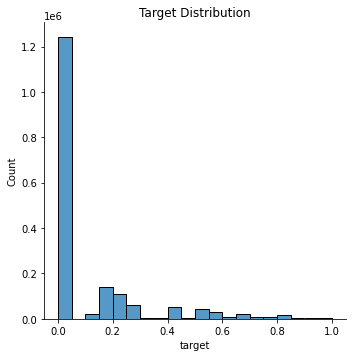

In [ ]:
plt.figure(figsize=(8, 8))
sns.displot(train['target'], bins=20, color='#db7563')
plt.title('Target Distribution');

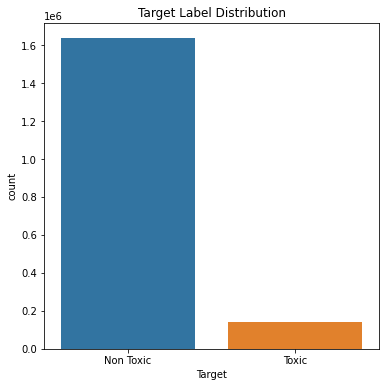

In [5]:
plt.figure(figsize=(6, 6))
sns.countplot(data = train, x = 'target_label', color='#db7563')
plt.xticks(ticks=[0, 1], labels=['Non Toxic', 'Toxic'])
plt.title('Target Label Distribution')
plt.xlabel('Target');

### Word Cloud

In [7]:
def plot_wordcloud(text_series, background, color):
    '''
    Plot the word cloud.
    '''
    cloud_text = ' '
    
    # Split text to words
    for i in text_series:
        cloud_text = cloud_text + ' ' + i
    
    wordcloud = WordCloud(height=500, 
                          width=1000, 
                          margin=0, 
                          background_color=background, 
                          colormap=color,
                          random_state=42).generate(cloud_text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

Below are the wordclouds for the different toxicity subgroups to understand which words come up in different categories.

**Severe Toxic**

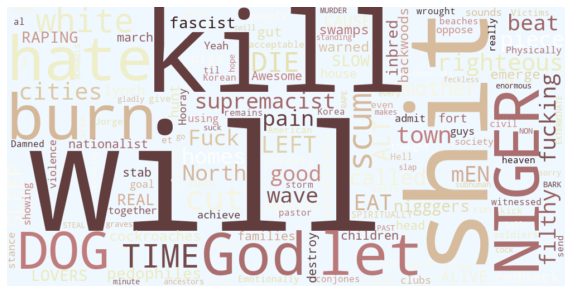

In [9]:
plot_wordcloud(train[train['severe_toxicity'] > 0.5]['comment_text'], 'aliceblue', 'pink')

**Obscene**

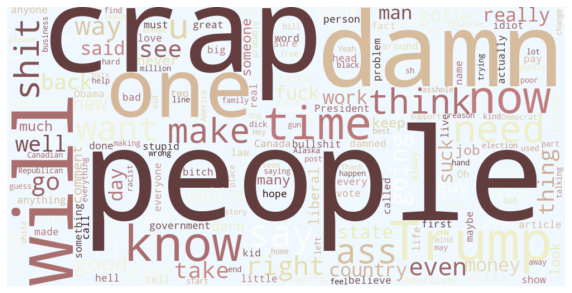

In [10]:
plot_wordcloud(train[train['obscene'] > 0.5]['comment_text'], 'aliceblue', 'pink')

**Identity Attack**

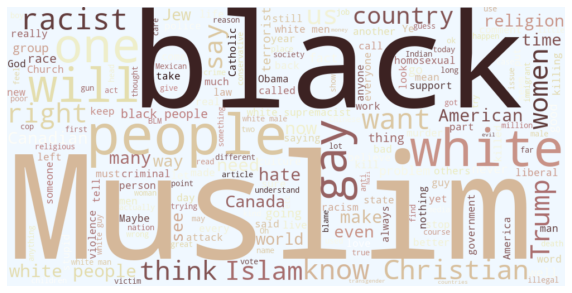

In [11]:
plot_wordcloud(train[train['identity_attack'] > 0.5]['comment_text'], 'aliceblue', 'pink')

**Insult**

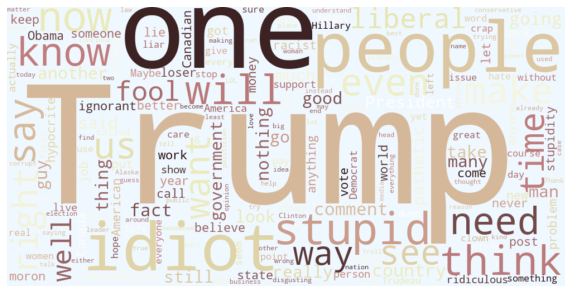

In [12]:
plot_wordcloud(train[train['insult'] > 0.5]['comment_text'], 'aliceblue', 'pink')

**Threat**

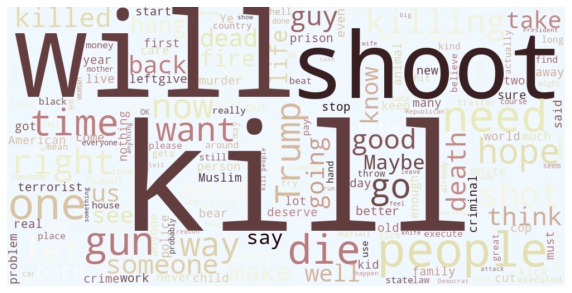

In [13]:
plot_wordcloud(train[train['threat'] > 0.5]['comment_text'], 'aliceblue', 'pink')